In [1]:
# import os
# os.environ['JAX_PLATFORMS'] = 'cpu'

# This is required to run multiple processes with JAX.
from multiprocessing import set_start_method
set_start_method('spawn', force=True)

In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import config, data, models, train, evaluate

In [3]:
run_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/source_experiments/e5_sr_20250817_170314")

fig_dir = run_dir / "figures" 
fig_dir.mkdir(exist_ok=True, parents=True)

In [4]:
trainer = train.Trainer.load_last_checkpoint(run_dir)
cfg = trainer.cfg

Model contains 29,517 parameters, using 115.30KB memory.
Creating new Trainer instance...
Logging at /nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/source_experiments/e5_sr_20250817_170314


In [5]:
cfg.quiet = False
dataset = data.HydroDataset(cfg)
# dataloader = data.HydroDataLoader(cfg, dataset)

Loading graph network file
Loading static attributes
Loading dynamic data
Data Hash: d18a4d49508abb4d2e184d577afada2196baca575e8b738bd6d83fe92c95765e
Using cached basin dataset.


In [6]:
test_cfg = cfg.model_copy()

In [7]:
test_cfg.attributes_file = Path('/nas/cee-water/cjgleason/ted/swot-ml/data/distributed/attributes/Upper_Miss_attributes.csv')
test_cfg.train_basin_file = Path('/nas/cee-water/cjgleason/ted/swot-ml/data/distributed/metadata/site_lists/Upper_Miss_all.txt')
test_cfg.test_basin_file = Path('/nas/cee-water/cjgleason/ted/swot-ml/data/distributed/metadata/site_lists/Upper_Miss_all.txt')
test_cfg.graph_network_file = Path('/nas/cee-water/cjgleason/ted/swot-ml/data/distributed/metadata/Upper_Miss_graph.json')

In [8]:
test_dataset = data.HydroDataset(test_cfg, train_ds = dataset)
dataloader = data.HydroDataLoader(cfg, test_dataset)

Loading graph network file
Loading static attributes
Loading dynamic data
Data Hash: f18461886c8c1ed79ee7b58821d371fb16d88bb600d31b03ae0789bc6a764039
Using cached basin dataset.
Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


In [9]:
results = evaluate.predict(trainer.model, dataloader)

100%|██████████| 108/108 [06:41<00:00,  3.72s/it]


In [10]:
basin_metrics = evaluate.get_basin_metrics(results)

(-1.0, 1.0)

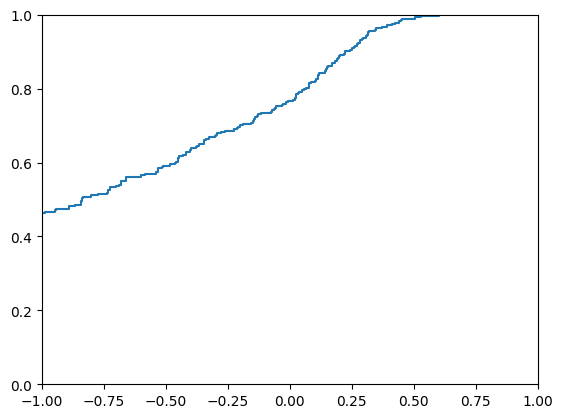

In [11]:
kge = basin_metrics['discharge']['KGE'].dropna().astype(float).values
plt.ecdf(kge)
plt.xlim((-1,1))

In [12]:
np.median(kge)

-0.8375824646452588

<Axes: xlabel='date'>

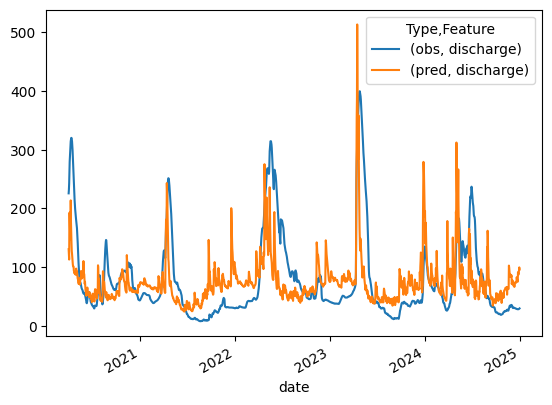

In [13]:
results.xs('7090369400', level='basin').sort_index().plot()

In [14]:
proj_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/distributed")
metadata_dir = proj_dir / "metadata"
basins = gpd.read_file(metadata_dir / 'Upper_Miss_matchups.geojson').set_index("HYBAS_ID")
basins.index = basins.index.astype(str)
basin_metrics = basins.join(basin_metrics['discharge'])

<Axes: >

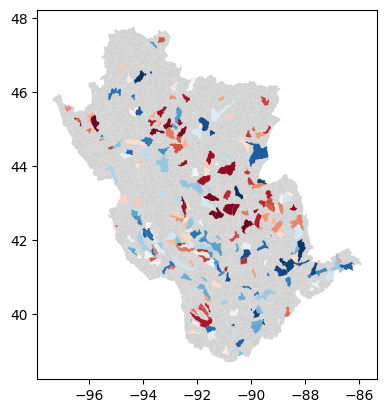

In [15]:
import matplotlib.colors as colors

norm = colors.LogNorm(vmin=-1, vmax=1)

fig, ax = plt.subplots()
basin_metrics.plot(ax=ax, color='lightgrey')
basin_metrics.plot('KGE',cmap='RdBu', ax=ax)

(-1.0, 1.0)

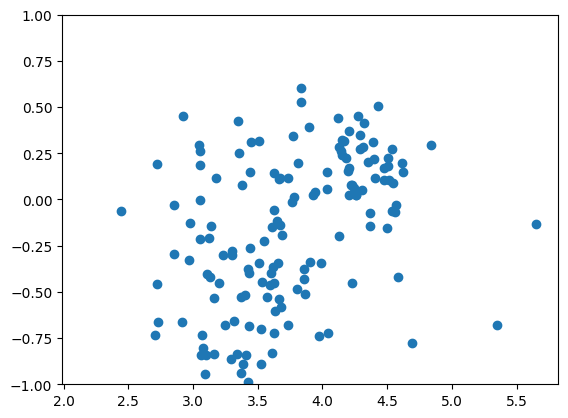

In [16]:
plt.scatter(np.log10(basin_metrics['area']),basin_metrics['KGE'])
plt.ylim((-1,1))